In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
import scipy.stats


In [2]:
def get_paths_rf(dset, fair, meth):
    rf_test = './{}_{}/rf_10-9_10_{}/'.format(dset, fair, meth)
    rf_train = './{}_{}/train_rf_10-9_10_{}/'.format(dset, fair, meth)
    rf_test_b = './{}_{}/baseline_rf_13-9_25_perc/'.format(dset, fair)
    rf_train_b = './{}_{}/baseline_train_rf_13-9_25_perc/'.format(dset, fair)
    lam_test = './{}_{}/rf_10-9_10_{}/'.format(dset, fair, 'lambda')
    lam_train = './{}_{}/train_rf_10-9_10_{}/'.format(dset, fair, 'lambda')
    return rf_test, rf_train, rf_test_b, rf_train_b, lam_test, lam_train

In [3]:
def get_paths_dt(dset, fair, meth):
    test = './{}_{}/dt_9-9_10_{}/'.format(dset, fair, meth)
    train = './{}_{}/train_dt_9-9_10_{}/'.format(dset, fair, meth)
    test_b = './{}_{}/baseline_dt_13-9_10_perc/'.format(dset, fair)
    train_b = './{}_{}/baseline_train_dt_13-9_10_perc/'.format(dset, fair)
    lam_test = './{}_{}/dt_9-9_10_{}/'.format(dset, fair, 'lambda')
    lam_train = './{}_{}/train_dt_9-9_10_{}/'.format(dset, fair, 'lambda')
    return test, train, test_b, train_b, lam_test, lam_train

In [26]:
plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'axes.labelsize': 20,
          'axes.titlesize': 20,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'legend.title_fontsize': 16,
          'legend.fontsize': 16,
          'legend.handlelength': 1,
          'figure.autolayout': 1,
          'font.size': 20,
          "figure.figsize": (6,4),
           'text.usetex' : True,
            'font.family' : 'lmodern'}
plt.rcParams.update(params)

/var/folders/1y/3mt7fkvd4s1bm0m2bp4fqyh00000gn/T/ipykernel_2478/3646224204.py:1: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]


In [66]:
def plot(train, test, trainb, testb, train_l, test_l, x, dset, save_path):
    fig = plt.figure()
    plt.figure().clear()
    plt.close()
    plt.cla()
    plt.clf()
    frames = []
    y = 'accuracy'

    for data in [train, test]:
        # multiple y per x value
        plot_df = data[0][[x, y, 'threshold', 'seed']].replace([np.inf, -np.inf], np.nan)
        plot_df.columns = plot_df.columns[:2].tolist() + ['threshold', 'seed']
        plot_df.sort_values(by=['seed', x], inplace=True)
        ## INTERPOLATE DATA FOR PLOTTING
        all_x_values = plot_df[x].unique()
        seeds = plot_df['seed'].unique()
        for seed in seeds:
            per_seed_df = plot_df.loc[plot_df['seed'] == seed]
            xp = per_seed_df[x].values
            fp = per_seed_df[y].values

            x_values = sorted(list(set(all_x_values).difference(set(np.unique(xp)))))
            interpolated_df = {x: x_values, y: np.interp(x_values, xp, fp),
                               'seed': [seed] * len(x_values), 'threshold': [np.nan] * len(x_values)}
            plot_df = plot_df.append(pd.DataFrame.from_dict(interpolated_df), ignore_index=True)
        plot_df['Fairness type'] = [x] * len(plot_df)
        plot_df.sort_values(by=['seed', x], inplace=True)
        plot_df = plot_df.rename(columns={x: 'Unfairness'})
        frames.append(plot_df)


    # sb.lineplot(data=dp, x='dp_diff', y='accuracy')
    # df = pd.concat(frames, ignore_index=True)
    trainb = train_b[0]
    meany, lowy, uppery = mean_confidence_interval(trainb[y])
    lowy = abs(meany-lowy)
    uppery = abs(meany-uppery)
    meanx, lowx, upperx = mean_confidence_interval(trainb[x])
    lowx = abs(meanx-lowx)
    upperx = abs(meanx-upperx)
    plt.errorbar(meanx, meany, xerr=[[lowx], [upperx]], yerr=[[lowy], [uppery]], marker="*", 
                 color='darkblue', label="Original (Train)", zorder=20, capsize=10, linewidth=3)
    testb = test_b[0]
    meanyt, lowyt, upperyt = mean_confidence_interval(testb[y])
    lowyt = abs(meanyt-lowyt)
    upperyt = abs(meanyt-upperyt)
    meanxt, lowxt, upperxt = mean_confidence_interval(testb[x])
    lowxt = abs(meanxt-lowxt)
    upperxt = abs(meanxt-upperxt)
    plt.errorbar(meanxt, meanyt, xerr=[[lowxt], [upperxt]], yerr=[[lowyt], [upperyt]], marker="*", 
                 color='darkorange', label="Original (Test)", capsize=10, zorder=20, linewidth=3)
    x_max = max([meanx+upperx, meanxt+upperxt])
    
    # lmbda=1 baseline
    trainl = train_l[0]
    trainl = trainl[trainl['threshold']==1.0]
    testl = test_l[0]
    testl = testl[testl['threshold']==1.0]
    print(testl)
    meanyl, lowyl, upperyl = mean_confidence_interval(trainl[y])
    lowyl = abs(meanyl-lowyl)
    upperyl = abs(meanyl-upperyl)
    meanxl, lowxl, upperxl = mean_confidence_interval(trainl[x])
    lowxl = abs(meanxl-lowxl)
    upperxl = abs(meanxl-upperxl)
    plotline, cap, barlinecols = plt.errorbar(meanxl, meanyl, xerr=[[lowxl], [upperxl]], 
                                              yerr=[[lowyl], [upperyl]], marker="o", 
                 color='red', label="Baseline (Train)", zorder=20, capsize=10, linewidth=3)
    plotline.set_solid_capstyle('round')
    cap[0].set_solid_capstyle('round')
    cap[1].set_solid_capstyle('round')

    
    meanytl, lowytl, upperytl = mean_confidence_interval(testl[y])
    lowytl = abs(meanytl-lowytl)
    upperytl = abs(meanytl-upperytl)
    meanxtl, lowxtl, upperxtl = mean_confidence_interval(testl[x])
    lowxtl = abs(meanxtl-lowxtl)
    upperxtl = abs(meanxtl-upperxtl)
    plotline, cap, barlinecols = plt.errorbar(meanxtl, meanytl, xerr=[[lowxtl], [upperxtl]], 
                                              yerr=[[lowytl], [upperytl]], marker="o", 
                 color='purple', label="Baseline (Test)", capsize=10, zorder=20, linewidth=3)
    plotline.set_solid_capstyle('round')
    cap[0].set_solid_capstyle('round')
    cap[1].set_solid_capstyle('round')    
    x_maxl = max([meanxl+upperxl, meanxtl+upperxtl])
    x_max = max([x_max, x_maxl])

    new_x='Unfairness'
    y='accuracy'
    print(frames[0].columns)
    sb.lineplot(data=frames[0][[new_x ,y , 'seed', 'Fairness type']].sort_values(by=['seed', new_x]), 
                x=new_x, y=y, estimator='mean', ci=95, color='b', label="PROFITT (Train)")
    sb.lineplot(data=frames[1][[new_x ,y , 'seed', 'Fairness type']].sort_values(by=['seed', new_x]), 
                x=new_x, y=y, estimator='mean', color='orange', ci=95, label="PROFITT (Test)")

    #plt.legend(ncol=6, loc='upper left')
    #plt.ylim((.6, .9))
    plt.xlim(right=x_max+.001)
    
    #plt.title(dset)
    if dset == 'COMPAS':
        plt.ylim((.4, .8))
    elif dset=='adult':
        plt.ylim((.7, .9))
    elif dset=='default_credit':
        plt.ylim((.8, 1))
    else:
        plt.ylim((.8, 1))
    plt.ylabel(y.capitalize())
    xlab = ""
    if x=="dp_diff":
        xlab = "Demographic Parity Gap"
    if x=="eodds_diff":
        xlab = "Equalized Odds Gap"
    plt.xlabel(xlab)
    
    #plt.gca().set_axis_off()
    ax = plt.gca()
    ax.get_legend().remove()
    plt.savefig('{}acc_v_unf_{}.pdf'.format(save_path, x), dpi=1000, facecolor='white', bbox_inches='tight')
    
    
    
    

In [67]:
def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

/var/folders/1y/3mt7fkvd4s1bm0m2bp4fqyh00000gn/T/ipykernel_2478/2058678957.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(pd.DataFrame.from_dict(interpolated_df), ignore_index=True)
/var/folders/1y/3mt7fkvd4s1bm0m2bp4fqyh00000gn/T/ipykernel_2478/2058678957.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  plot_df = plot_df.append(pd.DataFrame.from_dict(interpolated_df), ignore_index=True)


     Unnamed: 0  support  accuracy  precision    recall  \
500         500      498  0.877510   0.886555  0.983683   
501         501      498  0.871486   0.876310  0.988180   
502         502      498  0.889558   0.908696  0.969838   
503         503      498  0.905622   0.917927  0.979263   
504         504      498  0.877510   0.900442  0.962175   
505         505      498  0.883534   0.886555  0.990610   
506         506      498  0.917671   0.924078  0.986111   
507         507      498  0.881526   0.897380  0.971631   
508         508      498  0.885542   0.891667  0.988453   
509         509      498  0.879518   0.887712  0.983568   

                 conf_matrix  log_loss  selection_rate_neg  mean_prediction  \
500  [[ 15  54]\n [  7 422]]  4.230665            0.044177         0.044177   
501  [[ 16  59]\n [  5 418]]  4.438726            0.042169         0.042169   
502  [[ 25  42]\n [ 13 418]]  3.814544            0.076305         0.076305   
503  [[ 26  38]\n [  9 425]]  3.25

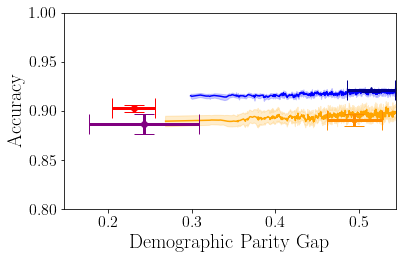

In [69]:
# PLOTS ACC V FAIRNESS
# test and train lines
#date = '12-8_10'
title = ""
for dset in ["CrimeCommunity"]:#, "COMPAS", "default_credit", "adult"]:
    for fair in ["DP"]:#, "DP"]:
        for method in ["thresh"]:
            #for x in ['dp_diff', 'eodds_diff']:
            if fair=='DP':
                x='dp_diff'
            else:
                x='eodds_diff'
            test, train, test_b, train_b, lam_test, lam_train = get_paths_rf(dset, fair, method)
            
#                 train = '../results/{}_{}/train_{}_{}/'.format(dset, fair, date, method)
#                 test = '../results/{}_{}/{}_{}/'.format(dset, fair, date, method)
#                 train_b = '../results/{}_{}/baseline_train_{}_perc/'.format(dset, fair, date)
#                 test_b = '../results/{}_{}/baseline_{}_perc/'.format(dset, fair, date)
            #train = read_frames('../results/COMPAS_EODDS/12-8_10_thresh/', 0)

            train = read_frames(train, 0)
            test = read_frames(test, 0)
            train_b = read_frames(train_b, 0)
            test_b = read_frames(test_b, 0)
            test_l = read_frames(lam_test, 0)
            train_l = read_frames(lam_train, 0)
            #save_to = "../results/{}_{}/{}_{}/".format(dset, fair, date, method)
            save_to = '/Users/sierrawyllie/Desktop/double_baselines/rf_plots/{}_{}_{}_'.format(dset, fair, method)
            #save_to = '/Users/sierrawyllie/Desktop/'.format(dset, fair, method)

            plot(train, test, train_b, test_b, train_l, test_l, x, dset, save_to)


In [7]:
def read_frames(dir_path, good_label):
    performances = pd.read_csv('{}overall_performance_seedwise.csv'.format(dir_path))
    # differences = pd.read_csv('{}group_differences_M-m_seedwise.csv'.format(dir_path))
    group_perfs = pd.read_csv('{}group_performances_seedwise.csv'.format(dir_path))

    # good label was passed to the script that formed these frames.
    if good_label == 0:
        # then selection rate is wrt label 0, we need wrt label 1
        performances['selection_rate_pos'] = 1 - performances['selection_rate']
        group_perfs['selection_rate_pos'] = 1 - group_perfs['selection_rate']
        # we also gotta get precision and recall for the 1 label (JKJKJKJK)
        # performances['recall'] = 1 - performances['recall']
        # performances['precision'] = 1 - performances['precision']
        # group_perfs['recall'] = 1 - group_perfs['recall']
        # group_perfs['precision'] = 1 - group_perfs['precision']
        performances = performances.rename(columns={'selection_rate': 'selection_rate_neg'})
        group_perfs = group_perfs.rename(columns={'selection_rate': 'selection_rate_neg'})
        # we also lowkey oopsied the pos/neg labels here :(
        oops_map = {'tnr': 'tpr', 'tpr': 'tnr', 'fpr': 'fnr', 'fnr': 'fpr'}
        performances = performances.rename(columns=oops_map)
        group_perfs = group_perfs.rename(columns=oops_map)
    else:
        performances['selection_rate_neg'] = 1 - performances['selection_rate']
        group_perfs['selection_rate_neg'] = 1 - group_perfs['selection_rate']
        performances = performances.rename(columns={'selection_rate': 'selection_rate_pos'})
        group_perfs = group_perfs.rename(columns={'selection_rate': 'selection_rate_pos'})
    return performances, group_perfs

In [8]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [9]:
def plot_performances(train, test, base_train, base_test, save_dir, xlabel):
    metrics = list(train.columns)
    print(metrics)
    unwanted = ['Unnamed: 0', 'support', 'seed', 'threshold', 'sensitive_feature_0', 'conf_matrix']
    for elem in unwanted:
        if elem in metrics:
            metrics.remove(elem)

    seeds = train['seed'].unique()
    cm_subsection = np.linspace(0, 1, len(seeds))
    colors = [plt.cm.tab10(x) for x in cm_subsection]

    for y in ['dp_diff', 'eodds_diff', 'accuracy']:  # metrics
        sb.lineplot(x="threshold", y=y, data=train, color='b', label="Train")
        sb.lineplot(x="threshold", y=y, data=test, color='orange', label="Test")
        if base_train is not None:
            mean, low, upper = mean_confidence_interval(base_train[y])
            plt.axhline(y=mean, color='b', linestyle='--')
            x = sorted(train['threshold'])
            plt.fill_between(x=x, y1=low, y2=upper, alpha=.1)
            
            mean, low, upper = mean_confidence_interval(base_test[y])
            plt.axhline(y=mean, color='orange', linestyle='--')
            x = sorted(test['threshold'])
            plt.fill_between(x=x, y1=low, y2=upper, alpha=.1)
        xlab = xlabel
        if xlabel == "thresh":
            xlab = "Threshold"
        elif xlabel == "lambda":
            xlab = "Lambda"
        plt.xlabel(xlab)
        if y == 'dp_diff':
            plt.ylabel('Demographic Parity Gap')
        elif y == "eodds_diff":
            plt.ylabel("Equalized Odds Gap")
        else:
            plt.ylabel(y.capitalize())
        # plt.legend(title='Set:')
        #plt.xlim((0, .05))
        plt.savefig('{}{}.png'.format(save_dir, y), dpi=300)
        print(y)
        plt.clf()